In [1]:
import numpy as np

class TicTacToeState:
    def __init__(self, board=None, turn=1):
        self.board = board if board is not None else np.zeros((3, 3), dtype=int)
        self.turn = turn  # 1 for player 1, -1 for player 2

    def is_done(self):
        # Check rows, columns, and diagonals for a win
        for i in range(3):
            if abs(sum(self.board[i, :])) == 3 or abs(sum(self.board[:, i])) == 3:
                return True
        if abs(sum(np.diag(self.board))) == 3 or abs(sum(np.diag(np.fliplr(self.board)))) == 3:
            return True
        # Check for draw
        if not np.any(self.board == 0):
            return True
        return False

    def legal_actions(self):
        return [(i, j) for i in range(3) for j in range(3) if self.board[i, j] == 0]

    def next_state(self, action):
        new_board = self.board.copy()
        new_board[action] = self.turn
        return TicTacToeState(new_board, -self.turn)

    def result(self):
        if self.is_done():
            for i in range(3):
                if abs(sum(self.board[i, :])) == 3:
                    return np.sign(sum(self.board[i, :]))
                if abs(sum(self.board[:, i])) == 3:
                    return np.sign(sum(self.board[:, i]))
            if abs(sum(np.diag(self.board))) == 3:
                return np.sign(sum(np.diag(self.board)))
            if abs(sum(np.diag(np.fliplr(self.board)))) == 3:
                return np.sign(sum(np.diag(np.fliplr(self.board))))
        return 0  # Draw or ongoing game

    def __str__(self):
        symbols = {1: "X", -1: "O", 0: "-"}
        return "\n".join([" ".join([symbols[self.board[i, j]] for j in range(3)]) for i in range(3)])



In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_policy_value_network():
    input_layer = layers.Input(shape=(3, 3, 1))

    # Residual Block
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(input_layer)
    for _ in range(3):  # Add 3 Residual Blocks
        residual = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
        residual = layers.Conv2D(64, (3, 3), padding="same")(residual)
        x = layers.add([x, residual])
        x = layers.ReLU()(x)

    # Policy Head, 가능한 모든 행동에 대한 확률 분포 출력 -> MCTS 탐색의 초기 확률로 사용
    policy = layers.Conv2D(2, (1, 1), activation="relu")(x)
    policy = layers.Flatten()(policy)
    policy_output = layers.Dense(9, activation="softmax", name="policy_output")(policy)

    # Value Head -> 상태의 승리 가능성을 [-1,1] 사이 값으로 출력 -> MCTS 탐색 중 시뮬레이션 단계에서 사용
    value = layers.Conv2D(1, (1, 1), activation="relu")(x)
    value = layers.Flatten()(value)
    value = layers.Dense(64, activation="relu")(value)
    value_output = layers.Dense(1, activation="tanh", name="value_output")(value)

    model = models.Model(inputs=input_layer, outputs=[policy_output, value_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss={"policy_output": "categorical_crossentropy", "value_output": "mse"})
    return model


In [3]:
import math

class MCTSNode:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = {}
        self.visits = 0
        self.value_sum = 0
        self.prior = 0

    def value(self):
        if self.visits == 0:
            return float('inf')  # 방문 횟수가 0이면 무한대 반환하여 탐험 유도
        return self.value_sum / self.visits # 노드의 평균 보상 리턴

    def ucb_score(self, total_visits): # 가장 유망한 자식 노드 탐색
        return self.value() + 1.5 * self.prior * math.sqrt(total_visits) / (1 + self.visits)

def mcts_policy_value(state, model, num_simulations=10):
    root = MCTSNode(state)
    for _ in range(num_simulations):
        node = root
        while node.children:
            node = max(node.children.values(), key=lambda n: n.ucb_score(root.visits))
        if not node.state.is_done():
            legal_actions = node.state.legal_actions()
            policy, value = model.predict(node.state.board.reshape(1, 3, 3, 1))
            policy = policy[0]
            for action, p in zip(legal_actions, policy):
                node.children[action] = MCTSNode(node.state.next_state(action), parent=node)
                node.children[action].prior = p
            value = value[0][0]
        else:
            value = node.state.result()

        while node:
            node.visits += 1
            node.value_sum += value
            value = -value  # Switch perspective
            node = node.parent

    # Normalize visits for policy
    total_visits = sum(child.visits for child in root.children.values())
    action_probabilities = [0] * 9
    for action, child in root.children.items():
        action_probabilities[action[0] * 3 + action[1]] = child.visits / total_visits
    return action_probabilities



In [4]:
import pickle

# 네트워크가 스스로 게임을 플레이하여 학습 데이터를 생성함
def self_play(model, num_games=5):
    data = []
    for _ in range(num_games):
        state = TicTacToeState()
        game_data = []
        while not state.is_done():
            policy = mcts_policy_value(state, model)
            flat_action = np.argmax(policy)  # 0~8 사이의 값
            action = (flat_action // 3, flat_action % 3)  # (row, col)로 변환
            game_data.append((state.board.copy(), policy))
            state = state.next_state(action)  # 올바른 (row, col) 전달
        result = state.result()
        for board, policy in game_data:
            data.append((board, policy, result)) # Replay Buffer -> 데이터가 안 버려지고 저장됨, train_model()에서 사용
    return data



def train_model(model, data):
    boards, policies, results = zip(*data)
    boards = np.array(boards).reshape(-1, 3, 3, 1)  # 입력 데이터 크기 (None, 3, 3, 1)
    policies = np.array(policies).reshape(-1, 9)    # 정책 데이터 크기 (None, 9)
    results = np.array(results).reshape(-1, 1)     # 가치 데이터 크기 (None, 1)

    history = model.fit(boards,
                        {"policy_output": policies, "value_output": results},
                        batch_size=16,
                        epochs=20,
                        verbose=1)
    return history


In [5]:
def evaluate_model(model, opponent, num_games=10):
    wins, losses, draws = 0, 0, 0
    for _ in range(num_games):
        state = TicTacToeState()
        while not state.is_done():
            if state.turn == 1:
                action = mcts_policy_value(state, model, num_simulations=10)
                action_flat = np.argmax(action)  # 0~8 중 최대값의 인덱스
                action = (action_flat // 3, action_flat % 3)  # (row, col) 변환
            else:
                action = opponent(state)
            assert isinstance(action, tuple) and len(action) == 2, f"Invalid action: {action}"  # 추가 검증
            state = state.next_state(action)
        result = state.result()
        if result == 1:
            wins += 1
        elif result == -1:
            losses += 1
        else:
            draws += 1
    return wins, losses, draws # 승/패/무승부를 통해 성능 측정



Cycle 1/10
------------------------------
Generating self-play data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━

Evaluation Results - Wins: 15, Losses: 5, Draws: 0

Model saved as 'model_cycle_1.h5'
Cycle 2/10
------------------------------
Generating self-play data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━

Evaluation Results - Wins: 15, Losses: 4, Draws: 1

Model saved as 'model_cycle_2.h5'
Cycle 3/10
------------------------------
Generating self-play data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━

Evaluation Results - Wins: 16, Losses: 4, Draws: 0

Model saved as 'model_cycle_3.h5'
Cycle 4/10
------------------------------
Generating self-play data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━

Evaluation Results - Wins: 17, Losses: 3, Draws: 0

Model saved as 'model_cycle_4.h5'
Cycle 5/10
------------------------------
Generating self-play data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━

Evaluation Results - Wins: 15, Losses: 5, Draws: 0

Model saved as 'model_cycle_5.h5'
Cycle 6/10
------------------------------
Generating self-play data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━

Evaluation Results - Wins: 15, Losses: 5, Draws: 0

Model saved as 'model_cycle_6.h5'
Cycle 7/10
------------------------------
Generating self-play data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━

Evaluation Results - Wins: 17, Losses: 0, Draws: 3

Model saved as 'model_cycle_7.h5'
Cycle 8/10
------------------------------
Generating self-play data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━

Evaluation Results - Wins: 18, Losses: 2, Draws: 0

Model saved as 'model_cycle_8.h5'
Cycle 9/10
------------------------------
Generating self-play data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━

Evaluation Results - Wins: 17, Losses: 3, Draws: 0

Model saved as 'model_cycle_9.h5'
Cycle 10/10
------------------------------
Generating self-play data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━

Evaluation Results - Wins: 15, Losses: 4, Draws: 1

Model saved as 'model_cycle_10.h5'


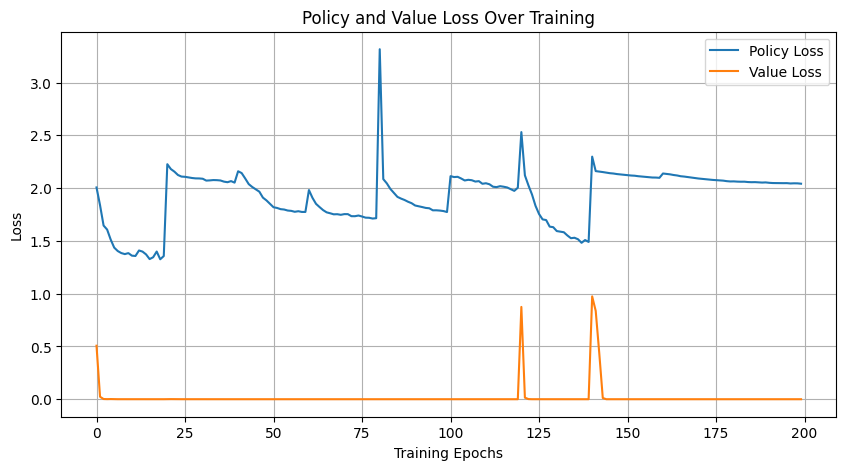

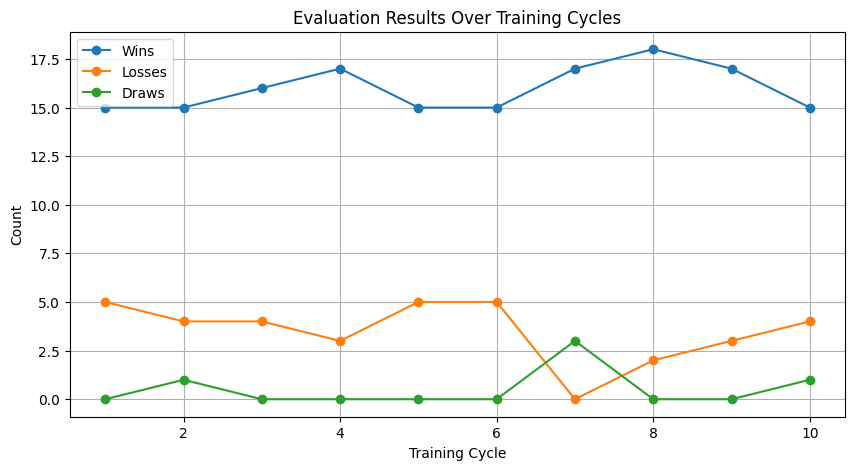

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random  # Add this import

def train_and_evaluate(model, num_cycles=10, num_games_per_cycle=20, num_eval_games=20):
    total_policy_losses = []
    total_value_losses = []
    evaluation_results = []

    for cycle in range(1, num_cycles + 1):
        print(f"Cycle {cycle}/{num_cycles}")
        print("-" * 30)

        # Self-Play
        print("Generating self-play data...")
        data = self_play(model, num_games=num_games_per_cycle)
        print(f"Generated {len(data)} game states.")

        # Training
        print("Training network...")
        history = train_model(model, data)

        # Collect loss data
        policy_loss = history.history["policy_output_loss"]
        value_loss = history.history["value_output_loss"]
        total_policy_losses.extend(policy_loss)
        total_value_losses.extend(value_loss)

        print(f"Policy Loss (last epoch): {policy_loss[-1]:.4f}")
        print(f"Value Loss (last epoch): {value_loss[-1]:.4f}")

        # Evaluation
        print("Evaluating model...")
        wins, losses, draws = evaluate_model(model, random_opponent, num_games=num_eval_games)
        evaluation_results.append((wins, losses, draws))
        print(f"Evaluation Results - Wins: {wins}, Losses: {losses}, Draws: {draws}")
        print()

        # Save the model after each cycle
        model.save(f"model_cycle_{cycle}.h5")
        print(f"Model saved as 'model_cycle_{cycle}.h5'")

    # Plot losses over cycles
    plt.figure(figsize=(10, 5))
    plt.plot(total_policy_losses, label="Policy Loss")
    plt.plot(total_value_losses, label="Value Loss")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.title("Policy and Value Loss Over Training")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot evaluation results
    wins, losses, draws = zip(*evaluation_results)
    cycles = range(1, num_cycles + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(cycles, wins, marker="o", label="Wins")
    plt.plot(cycles, losses, marker="o", label="Losses")
    plt.plot(cycles, draws, marker="o", label="Draws")
    plt.xlabel("Training Cycle")
    plt.ylabel("Count")
    plt.title("Evaluation Results Over Training Cycles")
    plt.legend()
    plt.grid()
    plt.show()

# Define a random opponent for evaluation
def random_opponent(state):
    # Randomly select a valid move
    valid_moves = state.legal_actions()  # Assuming legal_actions() gives valid moves
    action = random.choice(valid_moves)
    return action

# Initialize model
model = create_policy_value_network()

# Run training and evaluation
train_and_evaluate(model)
